# Proposal

## Introduction


Heart disease is a general term for a variety of conditions that affect your heart and blood vessels. These conditions can damage your heart, restrict blood flow, and lead to serious complications, including heart attack, stroke, and heart failure. With 20.5 million U.S. adults have coronary artery disease, heart disease is the leading cause of death in the United States (U.S. Department of Health and Human Services, 2023). 

Age is a major risk factor for heart disease due to several factors. Arteries stiffen and weaken, reducing blood flow and putting strain on the heart. Plaque buildup in arteries worsens with age, further restricting blood flow and increasing the risk of heart attack and stroke (Rodgers, J. L. et al., 2019).

Chronically high blood presssure can damage arteries, making them more prone to plaque buildup and narrowing (Centers for Disease Control and Prevention, 2021).

High levels of LDL cholesterol, often called "bad" cholesterol, can contribute to heart disease by accumulating in arteries and forming plaque. This plaque narrows the arteries, reducing blood flow and increasing the risk of complications like chest pain, blood clots, heart attack, and stroke(Centers for Disease Control and Prevention, 2017).

Based on the research our team found, we will be using the UC Irvine Heart Disease dataset in order to answer the following research question.
The dataset that we are using explores 271 patients and their situation across multiple variables, and finally classifying if they have heart disease. With that in mind, we formed the following classification question:

**Research Question:** Can we classify if a patient has heart disease based on age, blood pressure and cholesterol? 

## Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor) #Install to use the clean_names() function.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#The data set for heart disease was upload first to GitHub and, using the GitHub link, we read the file with the read_csv function. 
heart <- read_csv("https://raw.githubusercontent.com/jake-fung/DSCI100-002-031-GroupProject/main/data/Heart_Disease_Prediction.csv?token=GHSAT0AAAAAACPBQC4C2ZZQCWQSIKDWFDPCZPM6QOQ") 
#Cleaning the names of the columns.
heart <- clean_names(heart)

#Converting the heart_disease variable to be a factor instead of character
heart <- heart |>
mutate(heart_disease = as_factor(heart_disease))

#Splitting the data into the training data and testing data
#Training data is 80% and the testing data is 20%
heart_split <- initial_split(heart, prop = 0.80, strata = heart_disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

#Selecting the variables that we are using for our model and plots
heart_filtered <- heart_train |>
select(age, bp, cholesterol, heart_disease)

#Getting the summary statistics for the average in each variable, excluding heart_disease
heart_mean <- heart_filtered|>
select(-heart_disease) |>
map_df(mean)

#Counting the number of heart disease present or absent in the training data set
heart_amount <- heart_filtered|>
group_by(heart_disease) |>
summarize(amount=n())

# Table including summary data for both Presence and Absence groups.  
#Combining the two data frames together to create single table of data anaklysis
heart_summary_1 <- bind_cols(heart_mean, heart_amount) |>
pivot_wider(names_from=heart_disease,
            values_from=amount) |>
rename(age_avg=age, bp_avg=bp, chol_avg=cholesterol, hd_absence=Absence, hd_presence=Presence)
heart_summary_1

# Table for summary statistics of the Presence and Absence groups seperately.
#Using group_by(), to create two subsets and calculating the average for each variable
heart_summary_2 <- heart_train |>
group_by(heart_disease) |>
summarize(patients = n(),
         avg_age = mean(age),
         chol_avg = mean(cholesterol),
         bp_avg = mean(bp))
heart_summary_2

Rows: 270 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Heart Disease
dbl (13): Age, Sex, Chest pain type, BP, Cholesterol, FBS over 120, EKG resu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age_avg,bp_avg,chol_avg,hd_presence,hd_absence
<dbl>,<dbl>,<dbl>,<int>,<int>
54.375,130.5556,250.0324,96,120


heart_disease,patients,avg_age,chol_avg,bp_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>
Presence,96,56.90625,258.3333,133.6875
Absence,120,52.35000,243.3917,128.0500


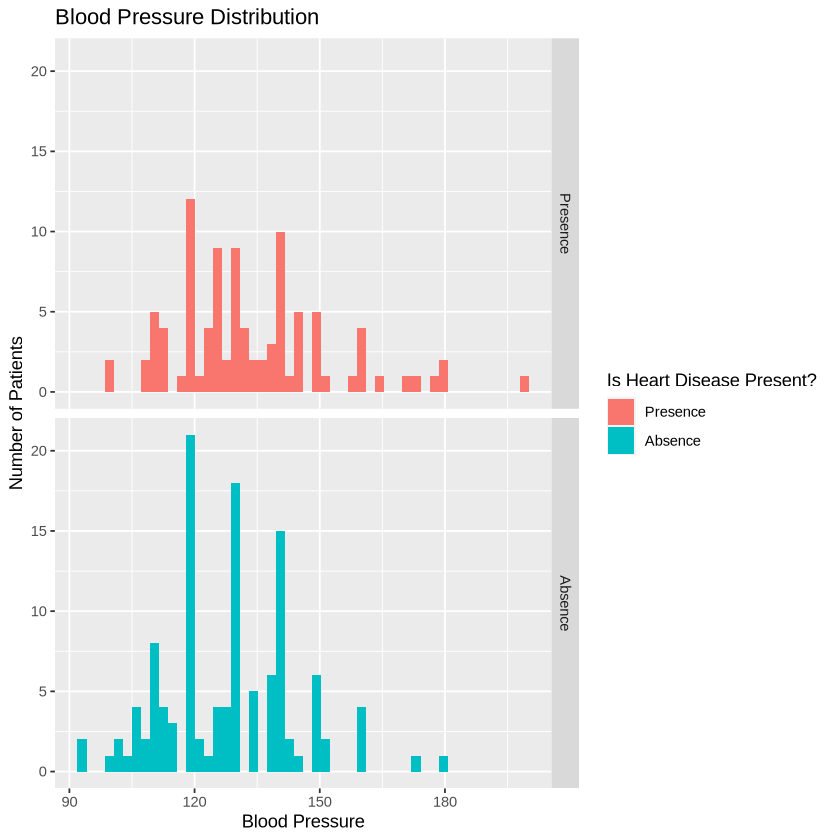

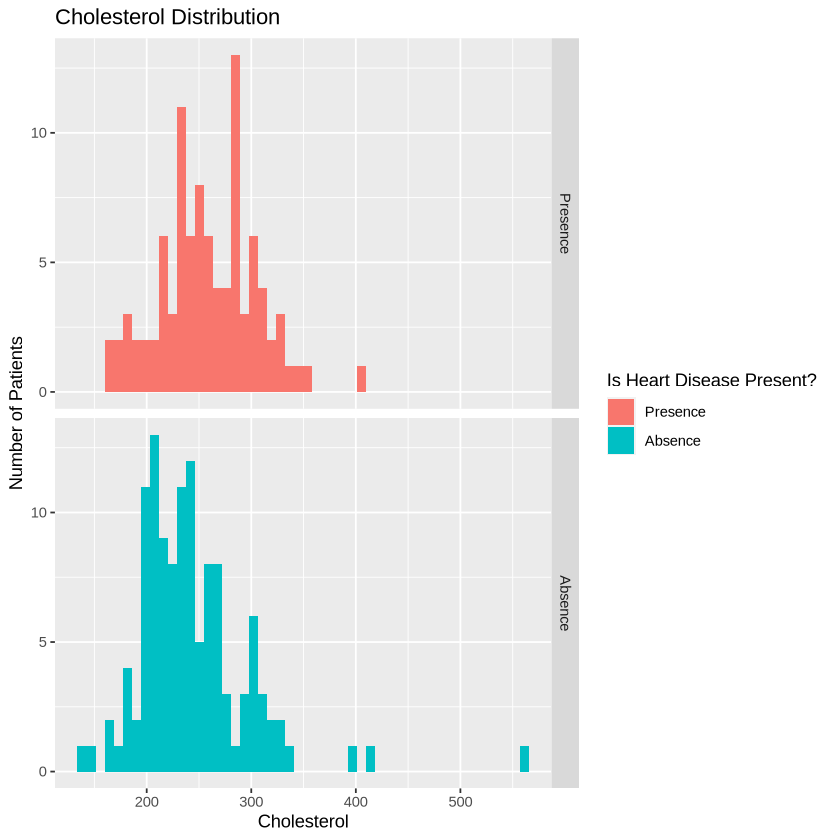

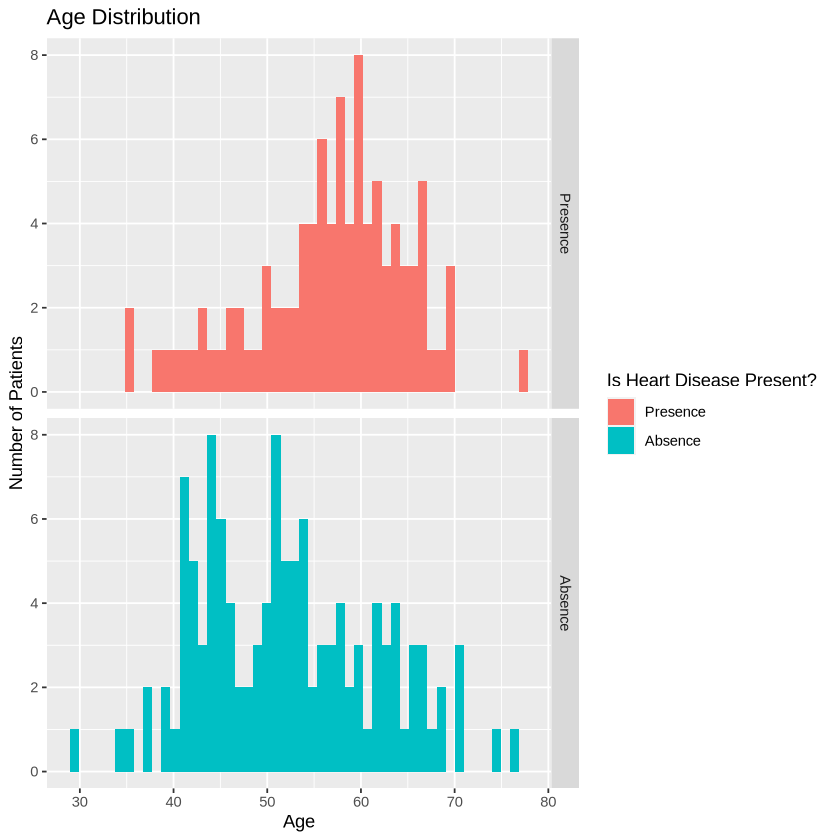

In [3]:
# To visualize our predictors we will use histogram to see the distribution of people with heart disease.
# This first graph will show the distribution of people with or without heart disease and their blood pressure.
histogram_bp <- heart_filtered |>
ggplot(aes(x = bp, fill = heart_disease)) +
geom_histogram(bins=50) +
facet_grid(vars(heart_disease))+
labs(x = "Blood Pressure", y = "Number of Patients", fill = "Is Heart Disease Present?")+
ggtitle("Blood Pressure Distribution")
histogram_bp

# This second graph will show the distribution of people with or without heart disease and their cholesterol.
histogram_ch <- heart_filtered |>
ggplot(aes(x = cholesterol, fill = heart_disease)) +
geom_histogram(bins=50) +
facet_grid(vars(heart_disease))+
labs(x = "Cholesterol", y = "Number of Patients", fill = "Is Heart Disease Present?")+
ggtitle("Cholesterol Distribution")
histogram_ch

# This third graph will show the distribution of people with or without heart disease and their age.
histogram_age <- heart_filtered |>
ggplot(aes(x = age, fill = heart_disease)) +
geom_histogram(bins=50) +
facet_grid(vars(heart_disease))+
labs(x = "Age", y = "Number of Patients", fill = "Is Heart Disease Present?")+
ggtitle("Age Distribution")
histogram_age

Looking at the graphs, there are visible bumps where heart disease is present in all of the graphs. Similarly, there are is a separate bump for the absent group. Only the blood pressure histogram is the data spread out; however, in the other histograms, the data is pretty much grouped together. 

# Methods
To answer our research question proposed above, we will be using 4 columns from the original dataset. We will create a histogram with each variable against the number of patients with heart disease to find if they are good predictors; an example of this is in the exploratory data analysis. Then, we will be using the K-nearest neighbours classification model with the heart disease column as the class and age, cholesterol, and blood pressure as the predictors. Since these values are not scaled, we will need to standardize these variables. Since we are using three numerical variables, we may need to use multiple graphs to visualize our results. An example of one graph may be a scatterplot with blood pressure and cholesterol with the presence of heart disease to differentiate the points. Then an unknown observation may be plotted on the same scatterplot with lines that lead to the nearest data points around it to see how our classifier performed the prediction. 


# Expected outcomes and significance:
Our research question aims to find the link between cholesterol, blood pressure, age, and heart disease. Based on previous research, we are aware that cholesterol, blood pressure, and age have a significant effect on your health. With our research, we wish to determine if we can classify if a person has heart disease based on the values of those variables. The impact of this is that we can become aware of any serious health issues that may arise before it is too late. In the future we could add more variables to these our model and find out if there are more outstanding variables that contribute to having heart disease.

## Biblography

Centers for Disease Control and Prevention. (2017). LDL & HDL: Good & Bad Cholesterol. Centers for Disease Control and Prevention. https://www.cdc.gov/cholesterol/ldl_hdl.htm 

Centers for Disease Control and Prevention. (2021, May 18). About high blood pressure (hypertension). Centers for Disease Control and Prevention. https://www.cdc.gov/bloodpressure/about.htm

Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019). Cardiovascular Risks Associated with Gender and Aging. Journal of Cardiovascular Development and Disease, 6(2). https://doi.org/10.3390/jcdd6020019

U.S. Department of Health and Human Services. (2023, December 20). What is coronary heart disease?. National Heart Lung and Blood Institute. https://www.nhlbi.nih.gov/health/coronary-heart-disease

World Health Organization. (2020). Hypertension. World Health Organization. https://www.who.int/health-topics/hypertension#tab=tab_1